<a href="https://colab.research.google.com/github/Shai670/Residential_consumption_modeling/blob/main/battery04.09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import clear_output

import matplotlib.pyplot as plt

In [2]:
!git clone https://github.com/Shai670/Residential_consumption_modeling
clear_output()

In [3]:
pv = pd.read_csv('/content/Residential_consumption_modeling/DATA/Kemerovo_2022_solcast_3.csv', index_col='time')
pv.index = pd.date_range(start='2022-01-01 07:00:00', freq='5MIN', periods=len(pv))
pv

,Solar
2022-01-01 07:00:00,-0.1
2022-01-01 07:05:00,-0.1
2022-01-01 07:10:00,-0.1
2022-01-01 07:15:00,-0.1
2022-01-01 07:20:00,-0.1
...,...
2023-01-01 06:35:00,-0.1
2023-01-01 06:40:00,-0.1
2023-01-01 06:45:00,-0.1
2023-01-01 06:50:00,-0.1


In [4]:
load = pd.read_csv("/content/Residential_consumption_modeling/DATA/load.csv", index_col=0)
load.index = pd.to_datetime(load.index)
load

,load
2022-01-01 07:00:00,1.620
2022-01-01 07:05:00,1.546
2022-01-01 07:10:00,1.550
2022-01-01 07:15:00,1.536
2022-01-01 07:20:00,1.534
...,...
2023-01-01 06:35:00,0.208
2023-01-01 06:40:00,0.206
2023-01-01 06:45:00,0.210
2023-01-01 06:50:00,0.208


In [5]:
class battery:


  def __init__(self, Pnom, capacity):
    self.Pnom = Pnom # номинальная мощность батареи
    self.capacity = capacity # ёмкость Вт*ч

    self.SOC_min = .20
    self.SOC_max = .85
    self.SOC = self.SOC_min

    #self.capacity_fact = self.SOC/100 * self.capacity

  def working (self, Pgen, Pload):
     Pbat = 0

     if Pgen > Pload:
       if self.SOC <= self.SOC_max:
         if (Pgen - Pload) >= self.Pnom:
           Pbat = self.Pnom
         elif (Pgen - Pload) < self.Pnom:
           Pbat = Pgen - Pload

     else:
       if self.SOC >= self.SOC_min:
         if Pload - Pgen >= self.Pnom:
           Pbat = -self.Pnom
         elif Pload - Pgen < self.Pnom:
           Pbat = -(Pload-Pgen)

     self.SOC += 5/60 * Pbat / self.capacity

     # self.capacity_fact += 1/60 * Pbat
     # self.SOC = self.capacity_fact / self.capacity * 100

     return Pbat


In [6]:
dataset = pd.merge(load, pv, left_index=True, right_index=True, how='outer').dropna()
dataset.loc[dataset['Solar'] < 0, 'Solar'] = 0
dataset['Solar'] *= 1e-3
dataset

,load,Solar
2022-01-01 07:00:00,1.620,0.0
2022-01-01 07:05:00,1.546,0.0
2022-01-01 07:10:00,1.550,0.0
2022-01-01 07:15:00,1.536,0.0
2022-01-01 07:20:00,1.534,0.0
...,...,...
2023-01-01 06:35:00,0.208,0.0
2023-01-01 06:40:00,0.206,0.0
2023-01-01 06:45:00,0.210,0.0
2023-01-01 06:50:00,0.208,0.0


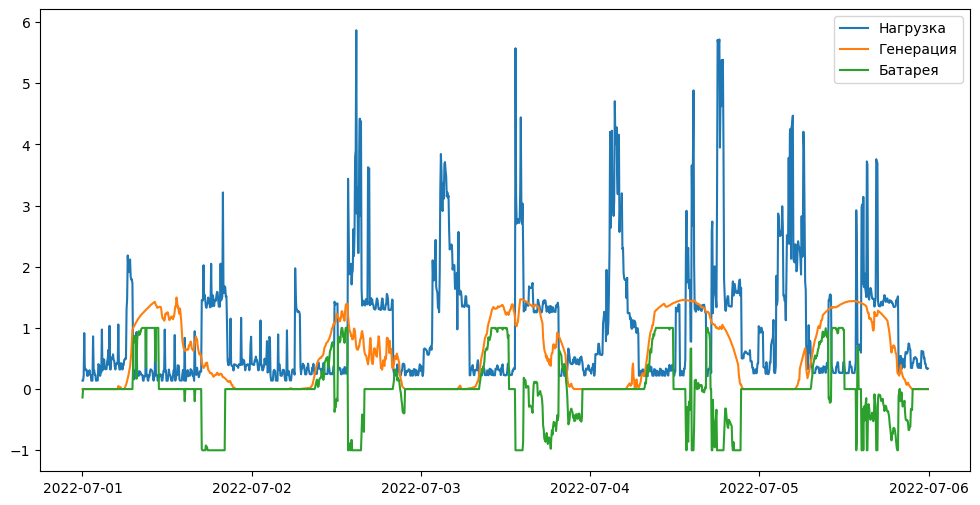

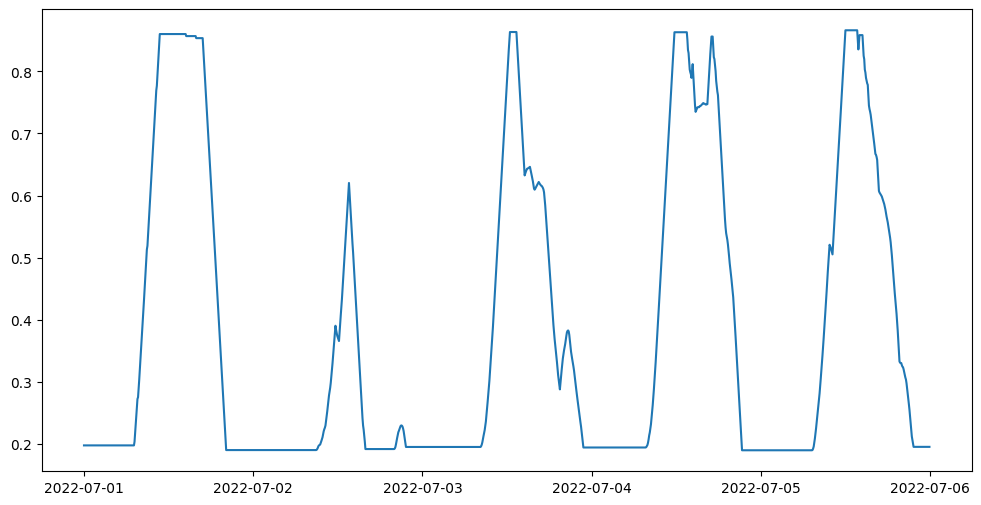

In [7]:
bat = battery(Pnom=1, capacity=5)

start = '2022-07-01'
end = '2022-07-05'

load_data = dataset['load'].loc[start : end]
gen_data  = dataset['Solar'].loc[start : end]

Pbat = []; soc = []; Pgrid = []
for load, gen in zip(load_data, gen_data):
  bat_power = bat.working(Pgen=gen, Pload=load)
  grid_power = load + bat_power - gen

  if grid_power < 0: grid_power = 0

  Pgrid.append(grid_power)
  Pbat.append(bat_power)
  soc.append(bat.SOC)

Pbat = pd.DataFrame({'bat' : Pbat}, index=load_data.index)
Pgrid = pd.DataFrame({'grid' : Pgrid}, index=load_data.index)
soc = pd.DataFrame({'soc' : soc}, index=load_data.index)

plt.figure(figsize=(12,6))
plt.plot(load_data, label='Нагрузка')
plt.plot(gen_data, label='Генерация')
plt.plot(Pbat, label='Батарея')

plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(soc, label='Нагрузка')
plt.show()

In [8]:
def solar_battery_calc(Pnom, capacity):
    bat = battery(Pnom=Pnom, capacity=capacity)

    load_data = dataset['load'].copy()
    gen_data  = dataset['Solar'].copy()

    Pbat = []; soc = []; Pgrid = []
    for load, gen in zip(load_data, gen_data):
        bat_power = bat.working(Pgen=gen, Pload=load)
        grid_power = load + bat_power - gen

        if grid_power < 0: grid_power = 0

        Pgrid.append(grid_power)
        Pbat.append(bat_power)
        soc.append(bat.SOC)

    output = pd.DataFrame(data={"Pbat" : Pbat, "SOC" : soc, "Pgrid" : Pgrid}, index=gen_data.index)

    return output

In [9]:
dataset['load'].mean() * 365 * 24

9375.378833333332

In [10]:
output = solar_battery_calc(Pnom=0, capacity=5)
output.mean() * 365 * 24 / 12

Pbat       0.000000
SOC      146.000000
Pgrid    663.932242
dtype: float64

In [11]:
output = solar_battery_calc(Pnom=3, capacity=10)
output.sum()

Pbat        -0.042501
SOC      30139.717148
Pgrid    85958.997645
dtype: float64

In [12]:
output = solar_battery_calc(Pnom=5, capacity=10)
output.sum()

Pbat        -0.043446
SOC      30013.490587
Pgrid    85956.008552
dtype: float64

In [13]:
output = solar_battery_calc(Pnom=7.2, capacity=20)
output.sum()

Pbat        -0.045632
SOC      27660.248870
Pgrid    85385.576667
dtype: float64

,p,c,W
0,0.0,5.0,93788.0
1,0.0,6.0,93788.0
2,0.0,6.0,93788.0
3,0.0,6.0,93788.0
4,0.0,7.0,93788.0
...,...,...,...
445,7.0,18.0,85463.0
446,7.0,18.0,85448.0
447,7.0,18.0,85432.0
448,7.0,19.0,85416.0


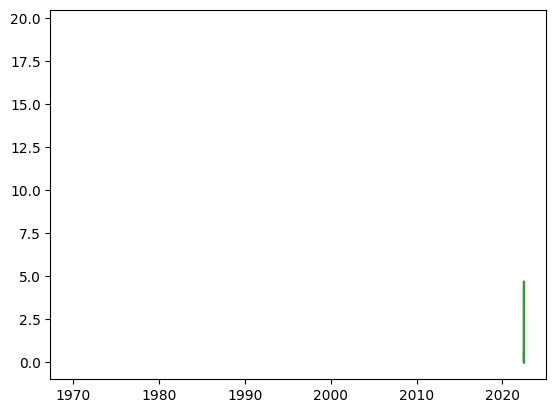

In [14]:
result = pd.DataFrame()

i = 0
for p in np.arange(0.1, 7.2, .05):
    for c in np.arange(5, 20, .05):
        output = solar_battery_calc(Pnom=p, capacity=c)

        result.loc[i, "p"] = p.round(0)
        result.loc[i, "c"] = c.round(0)
        result.loc[i, "W"] = output["Pgrid"].sum().round()

        i += 1
plt.plot(p, label='Мощность')
plt.plot(c, label='Ёмкость солнечной панели')
plt.plot(Pgrid, label='Электропотребелние')

result



In [15]:
result_pivot = pd.pivot_table(
    result, index="p", columns="c", values="W"
)
result_pivot

c,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
p,,,,,,,,,,,,,,,,
0.0,93788.0,93788.000000,93788.0,93788.000000,93788.0,93788.000000,93788.0,93788.000000,93788.0,93788.000000,93788.0,93788.000000,93788.0,93788.000000,93788.0,93788.0
1.0,88535.5,88031.666667,87657.0,87392.333333,87208.5,87104.333333,87021.5,86959.500000,86905.0,86862.000000,86823.5,86793.000000,86768.0,86744.166667,86720.5,86709.0
2.0,88169.5,87491.333333,86919.0,86478.333333,86158.5,85985.000000,85863.0,85762.666667,85676.5,85610.000000,85560.5,85522.000000,85487.5,85456.166667,85425.5,85409.5
3.0,88133.0,87457.666667,86885.0,86457.666667,86138.0,85964.500000,85835.0,85741.000000,85657.0,85597.500000,85552.0,85512.500000,85478.5,85447.000000,85416.0,85401.0
4.0,88114.5,87444.000000,86878.0,86447.000000,86132.5,85961.333333,85830.0,85738.166667,85657.0,85597.333333,85551.5,85513.166667,85479.0,85447.833333,85416.5,85401.0
5.0,88115.0,87439.333333,86878.0,86441.000000,86129.5,85958.500000,85830.0,85737.333333,85656.5,85595.333333,85550.5,85510.333333,85476.0,85445.333333,85413.5,85399.0
6.0,88112.0,87435.333333,86874.0,86442.333333,86128.5,85955.166667,85828.5,85734.333333,85654.0,85596.333333,85550.0,85511.833333,85478.5,85446.000000,85415.5,85400.0
7.0,88108.0,87438.666667,86877.0,86440.666667,86130.5,85958.000000,85833.0,85736.333333,85655.5,85597.333333,85551.5,85512.500000,85479.0,85447.333333,85416.0,85401.0


<Axes: xlabel='c', ylabel='p'>

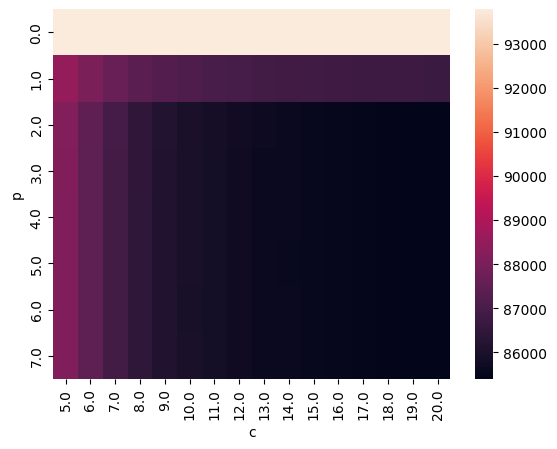

In [16]:
import seaborn as sns

sns.heatmap(result_pivot)